In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys 
from scipy.io import loadmat
from sklearn.decomposition import PCA
import colorcet as cc
import glasbey
sys.path.insert(1, '/Users/frederiekelohmann/Documents/FS2024/DSL/DSL_Quake_Fault_Reconstruction/benchmark/src')

from main import run_fault_reconstruction

In [2]:
def plot_3Ddataset(X: np.ndarray,
                 labels: np.ndarray,
                 marker_sz: float = 4.,
                 cmap = plt.get_cmap("cet_glasbey_bw")):
    
    '''
    Create every 2D combination plot from 3D data, colored according to labels
    '''
    
    fig, ax = plt.subplots(2,2)
    fig.set_figwidth(10)
    fig.set_figheight(10)

    ax[0,0].scatter(X[:,0], X[:,1], s=marker_sz, c=labels, cmap = cmap)
    ax[0,1].scatter(X[:,2], X[:,1], s=marker_sz, c=labels, cmap = cmap)
    ax[1,0].scatter(X[:,0], X[:,2]*-1, s=marker_sz, c=labels, cmap = cmap)

    ax[0,0].set_xlabel('x')
    ax[0,0].set_ylabel('y')
    ax[0,1].set_xlabel('z')
    ax[0,1].set_ylabel('y')
    ax[1,0].set_xlabel('x')
    ax[1,0].set_ylabel('z')

    ticks = np.linspace(np.max(X[:,2]), np.min(X[:,2]), 5)
    ticks = ax[1,0].get_yticks()[1:-1]
    ax[1,0].set_yticks(ticks, -1*ticks)

    ax[1,1].axis('off')

    return fig, ax


## Test on a Synthetic Dataset

In [3]:
ground_truth = np.load('../data/synthetics_31.npy')

In [4]:
y_true = []
cts_true = []
for i in range(len(ground_truth)):

    y_true += [i]*len(ground_truth[i])
    cts_true.append(len(ground_truth[i]))


X = np.concatenate(ground_truth, axis = 0)

In [5]:
kernels, labels = run_fault_reconstruction(X, min_sz_cluster = 4, align_t=0)

Processing chunk 1/1 with 400 points


  Fit 63 Gaussian and 1 background kernels
  BIC: 2337.118249562775
Number of nans in gain 0.0/2016.0
Nans from bbox check: 1979
Number nans after bbox check: 1979.0
  37/2016 pairs have touching bbox
  Removed 0/37 candidate pairs with negative gain
Nans from negative check: 0
Number nans after negative check: 1979.0
  Merged 12 pairs  >> 52 kernels left
  BIC: 2052.7240395489107
Number of nans in gain 776.0/1326.0
Nans from bbox check: 499
Number nans after bbox check: 1275.0
  51/550 pairs have touching bbox
  Removed 0/51 candidate pairs with negative gain
Nans from negative check: 0
Number nans after negative check: 1275.0
  Merged 5 pairs  >> 47 kernels left
  BIC: 1931.2866599430422
Number of nans in gain 839.0/1081.0
Nans from bbox check: 184
Number nans after bbox check: 1023.0
  58/242 pairs have touching bbox
  Removed 1/58 candidate pairs with negative gain
Nans from negative check: 1
Number nans after negative check: 1024.0
  Merged 6 pairs  >> 41 kernels left
  BIC: 1811.

### Plot the cluster assignment of the algorithm


We can see here one of the problems of using Gaussians in the algorithm: The yellow cluster contains datapoints from 2 faults in the ground truth

ValueError: 'c' argument has 3360 elements, which is inconsistent with 'x' and 'y' with size 400.

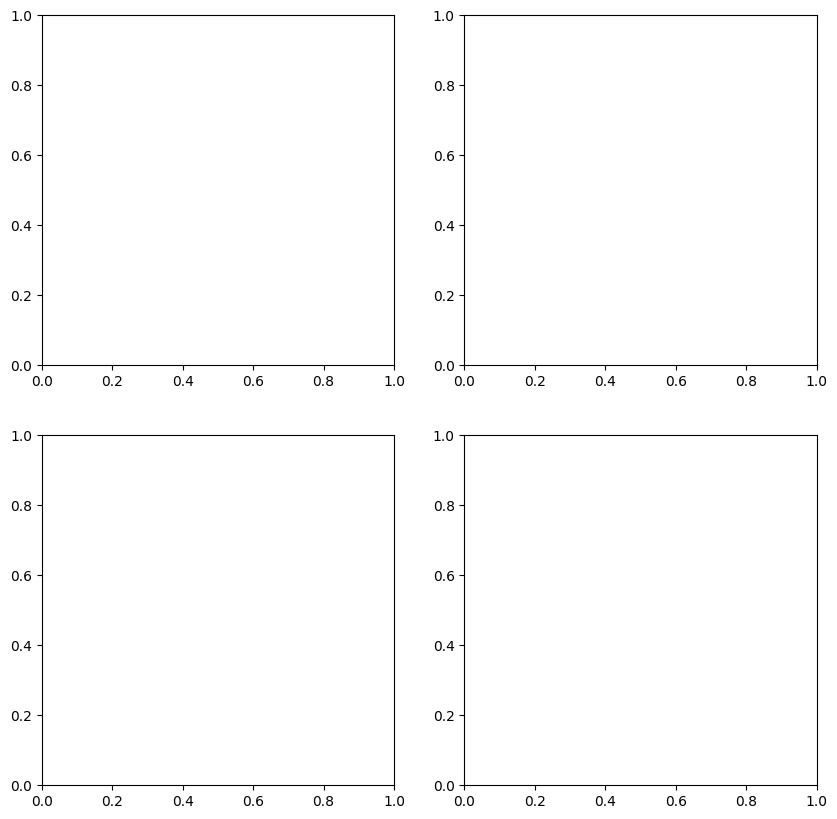

In [139]:
plot_3Ddataset(X, labels)

### Plot the ground truth

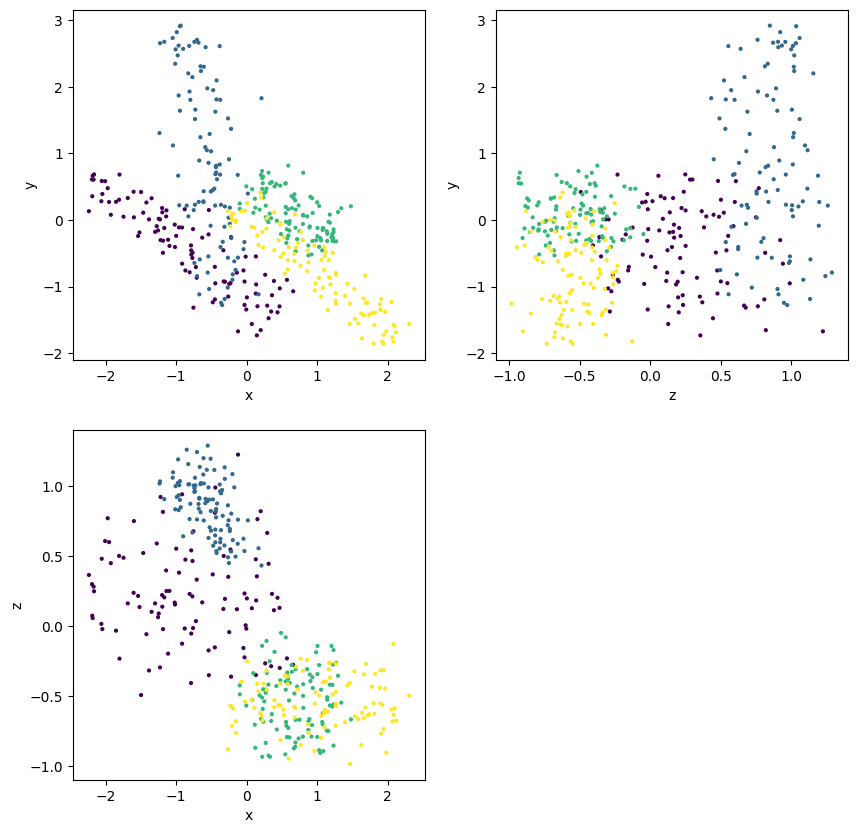

In [7]:
plot_3Ddataset(X, y_true)

## Test on Landers dataset

In [73]:
landers = loadmat('../data/landers.mat')['xyz_mat']

ker_plan, lab_plan= run_fault_reconstruction(landers, min_sz_cluster=4, align_t = 0.6)

Processing chunk 1/1 with 3360 points
  Fit 394 Gaussian and 1 background kernels
  Removed 1/395 kernels with < 4 points
  BIC: 41396.08805344613
Number of nans in gain 0.0/77421.0
Nans from bbox check: 77262
Number nans after bbox check: 77262.0
  159/77421 pairs have touching bbox
  Removed 0/159 candidate pairs with negative gain
Nans from negative check: 0
Number nans after negative check: 77262.0
  Merged 62 pairs  >> 332 kernels left
  BIC: 39231.10979703367
Number of nans in gain 36290.0/54946.0
Nans from bbox check: 18503
Number nans after bbox check: 54793.0
  153/18656 pairs have touching bbox
  Removed 0/153 candidate pairs with negative gain
Nans from negative check: 0
Number nans after negative check: 54793.0
  Merged 33 pairs  >> 299 kernels left
  BIC: 38098.64359150002
Number of nans in gain 35209.0/44551.0
Nans from bbox check: 9235
Number nans after bbox check: 44444.0
  107/9342 pairs have touching bbox
  Removed 1/107 candidate pairs with negative gain
Nans from ne

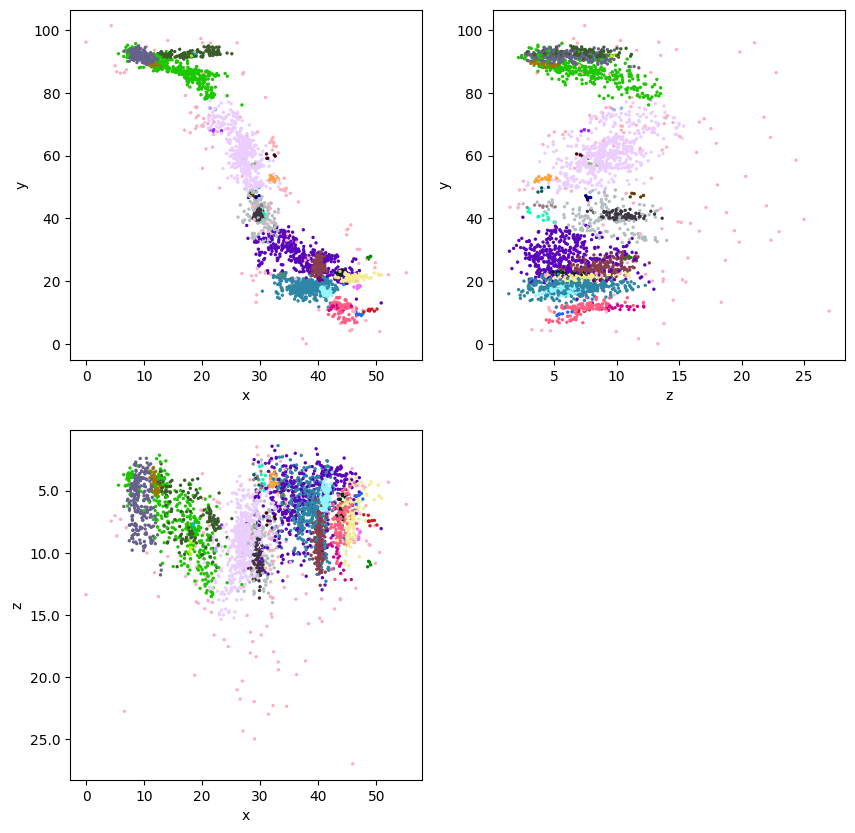

In [171]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(glasbey.create_palette(palette_size=len(np.unique(labels))))
plot_3Ddataset(landers, labels, marker_sz = 2, cmap = cmap)

### Planarity of the resulting clusters

In [11]:
def planarity_score(X: np.ndarray):

    if X.shape[1] != 3:
        raise ValueError(f'Data must be 3-dimensional, was {X.shape[1]}-dimensional')
    
    if X.shape[0] < 3:
        return 1
    
    # get the perc of variance explained by smallest principal component
    pca = PCA(n_components = 3, random_state=71)
    score = pca.fit(X).explained_variance_ratio_[2]

    return 1-score

In [93]:
def cluster_planarity(X: np.ndarray,
                      labs: np.ndarray):
    
    scores = {c: planarity_score(X[labs == c]) for c in np.unique(labs)}
    
    return scores

In [108]:
from kernelparameters import KernelParameters

def match_kernels(kernels1: KernelParameters,
                kernels2: KernelParameters
                ):

    # match the kernels
    msk1 = np.lexsort((kernels1.get('m')[:,0], kernels1.get('m')[:,1], kernels1.get('m')[:,2]))
    msk2 = np.lexsort((kernels2.get('m')[:,0], kernels2.get('m')[:,1], kernels2.get('m')[:,2]))

    pairs = []
    i = j = 0
    while i < len(msk1) or j < len(msk2):

        if j == len(msk2):
            pairs += list(zip(msk1[i:], [None]*(len(msk1)-i)))
            break

        elif i == len(msk1):
            pairs += list(zip([None]*(len(msk2)-j), msk2[j:]))
            break

        means = np.array([kernels1.get('m')[msk1[i]], kernels2.get('m')[msk2[j]]])

        if np.all(means[0] == means[1]):
            pairs.append((msk1[i], msk2[j]))
            i += 1
            j += 1

        elif np.lexsort((means[:,0], means[:,1], means[:,2]))[0] == 0:
            pairs.append((msk1[i], None))
            i += 1
        
        else :
            pairs.append((None, msk2[j]))
            j += 1

    
    return pairs



def compare_planarity(X: np.ndarray,
                      pairs: dict,
                      labels1: np.ndarray,
                      labels2: np.ndarray,
                      kernels1: KernelParameters,
                      kernels2: KernelParameters):
    
    # calculate planarity score of each cluster
    score1 = cluster_planarity(X, labels1)
    score2 = cluster_planarity(X, labels2)

    bkg_idx1 = np.arange(kernels1.get_n_kernels())[kernels1.get('ib')][0]
    bkg_idx2 = np.arange(kernels2.get_n_kernels())[kernels2.get('ib')][0]

    # remove the background
    del score1[bkg_idx1]
    del score2[bkg_idx2]

    pairs = [(l,r) for l,r in pairs if l != bkg_idx1 and r != bkg_idx2]

    matched_scores = [ (score1[l], score2[r]) for l,r in pairs if l is not None and r is not None ]

    return matched_scores
    

In [109]:
pairs = match_kernels(ker_og, ker_plan)
match_score = compare_planarity(landers, pairs, lab_og, lab_plan, ker_og, ker_plan)

### Compare to results without planarity constraint

In [20]:
ker_og, lab_og = run_fault_reconstruction(landers, min_sz_cluster=4, align_t=0)

Processing chunk 1/1 with 3360 points
  Fit 394 Gaussian and 1 background kernels
  Removed 1/395 kernels with < 4 points
  BIC: 41396.08805344613
Number of nans in gain 0.0/77421.0
Nans from bbox check: 77007
Number nans after bbox check: 77007.0
  414/77421 pairs have touching bbox
  Removed 0/414 candidate pairs with negative gain
Nans from negative check: 0
Number nans after negative check: 77007.0
  Merged 63 pairs  >> 331 kernels left
  BIC: 39104.024797098406
Number of nans in gain 35640.0/54615.0
Nans from bbox check: 18486
Number nans after bbox check: 54126.0
  489/18975 pairs have touching bbox
  Removed 1/489 candidate pairs with negative gain
Nans from negative check: 1
Number nans after negative check: 54127.0
  Merged 42 pairs  >> 289 kernels left
  BIC: 37664.001345753444
Number of nans in gain 30184.0/41616.0
Nans from bbox check: 10910
Number nans after bbox check: 41094.0
  522/11432 pairs have touching bbox
  Removed 4/522 candidate pairs with negative gain
Nans fro

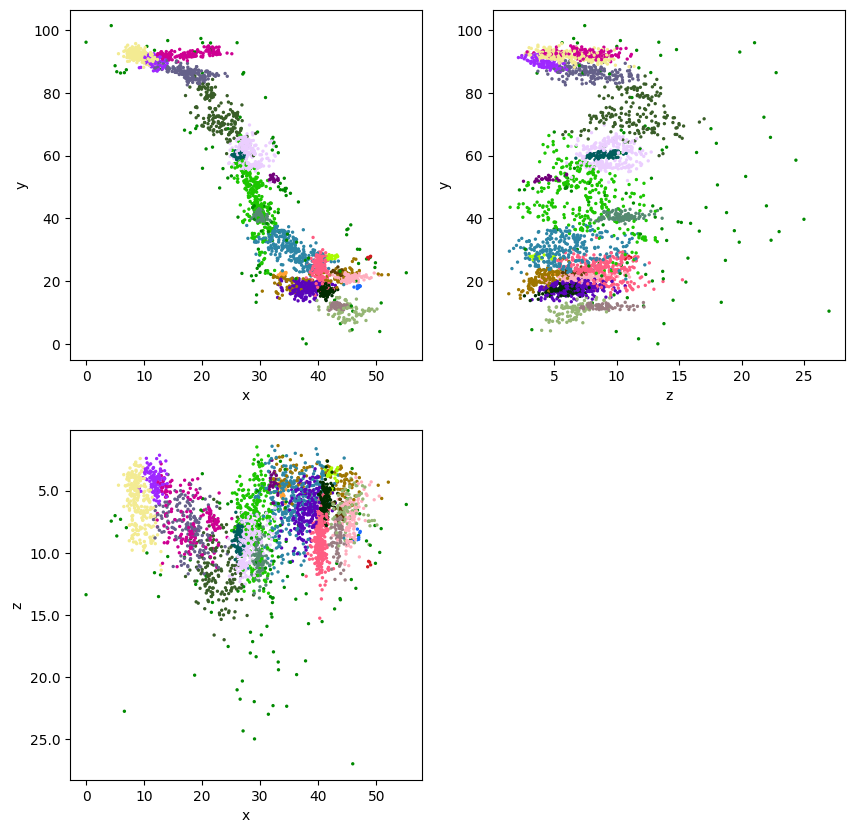

In [172]:
plot_3Ddataset(landers, lab_og, 2, cmap)

In [133]:
def test_range(X: np.ndarray,
                t_range: list):
    
    scores = []
    
    for t in t_range:

        ker, lab = run_fault_reconstruction(X, min_sz_cluster=4, align_t=t)
        scores.append(cluster_planarity(X, lab).values())


    return scores


def plot_range(scores: list,
               t_range: list,
               bins: int = 20,
               density: bool = False):
    
    start = np.min([np.min(v) for v in scores])
    
    for vals in scores:

        plt.hist(vals, bins = bins, range = (start, 1), alpha = 0.5, density=density)

    plt.legend(t_range, title = 'align_t')
    plt.show()

In [115]:
sc_rang = test_range(landers, [0, 0.5, 0.6, 0.7, 0.8])

Processing chunk 1/1 with 3360 points
  Fit 394 Gaussian and 1 background kernels
  Removed 1/395 kernels with < 4 points
  BIC: 41396.08805344613
Number of nans in gain 0.0/77421.0
Nans from bbox check: 77007
Number nans after bbox check: 77007.0
  414/77421 pairs have touching bbox
  Removed 0/414 candidate pairs with negative gain
Nans from negative check: 0
Number nans after negative check: 77007.0
  Merged 63 pairs  >> 331 kernels left
  BIC: 39104.024797098406
Number of nans in gain 35640.0/54615.0
Nans from bbox check: 18486
Number nans after bbox check: 54126.0
  489/18975 pairs have touching bbox
  Removed 1/489 candidate pairs with negative gain
Nans from negative check: 1
Number nans after negative check: 54127.0
  Merged 42 pairs  >> 289 kernels left
  BIC: 37664.001345753444
Number of nans in gain 30184.0/41616.0
Nans from bbox check: 10910
Number nans after bbox check: 41094.0
  522/11432 pairs have touching bbox
  Removed 4/522 candidate pairs with negative gain
Nans fro

In [137]:
# number of clusters with increasing align_t
[len(v) for v in sc_rang][:-1]

[24, 18, 34, 44]

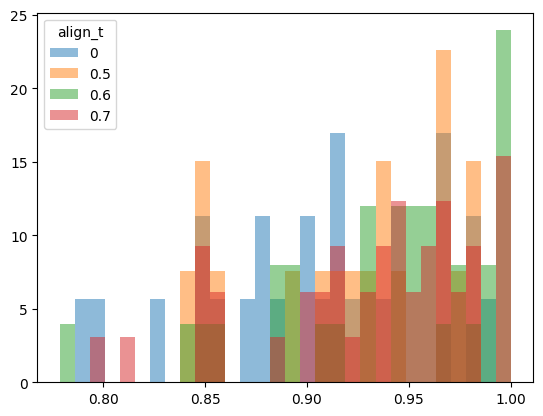

In [135]:
rang = [list(v) for v in sc_rang]
plot_range(rang[:-1], [0, 0.5, 0.6, 0.7], 30, True)

In [83]:
sc_og = cluster_planarity(landers, lab_og)
sc_plan = cluster_planarity(landers, lab_plan)

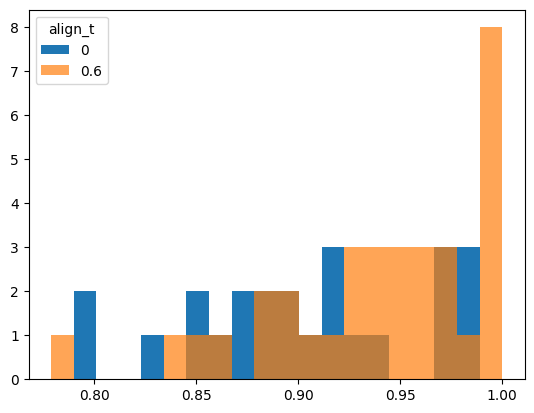

In [84]:
start = min(list(sc_og.values())+list(sc_plan.values()))
plt.hist(sc_og.values(), bins = 20, range= (start, 1))
plt.hist(sc_plan.values(), bins = 20, range= (start, 1), alpha = 0.7)
plt.legend([0, 0.6], title='align_t')
plt.show()

## Nice visualizations of the results

In [217]:
def plot_components(X: np.ndarray,
                    labels: np.ndarray,
                    marker_sz: float = 2.,
                    cmap = plt.get_cmap("cet_glasbey_light")):
    
    '''
    Plot the 3 principal components of the data as 3 plots

    Parameters
    -----------
    X: np.ndarray
        The data as an array of shape (n_samples, n_features)

    labels: np.ndarray
        An array of labels according to which the data points are colored

    
    Returns
    --------
    fig: matplotlib.figure.Figure
        The figure object
        
    ax: np.ndarray
        An array of shape (2,2) containing the ax objects of the figure
    '''

    # project the data onto PCs
    pca = PCA(n_components=X.shape[1], random_state=71)
    X = pca.fit_transform(X)

    # plot PCs
    fig, ax = plot_3Ddataset(X, labels, marker_sz, cmap)

    # rename axes
    ax[0,0].set_xlabel('PC 1')
    ax[0,0].set_ylabel('PC 2')
    ax[0,1].set_xlabel('PC 3')
    ax[0,1].set_ylabel('PC 2')
    ax[1,0].set_xlabel('PC 1')
    ax[1,0].set_ylabel('PC 3')

    return fig, ax

    

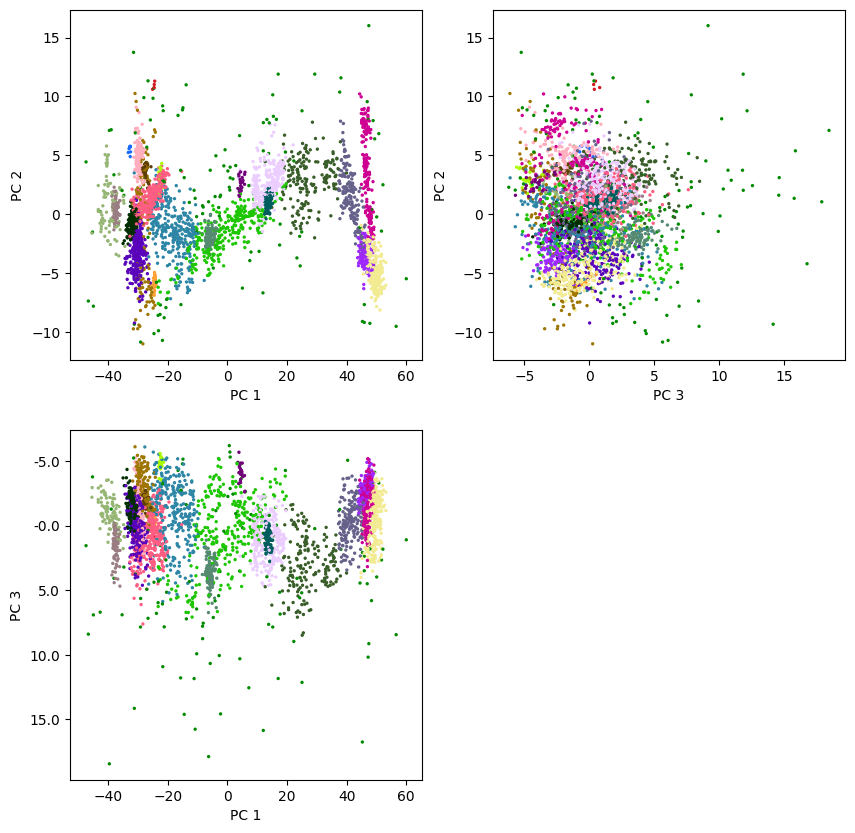

In [215]:
fig, ax = plot_components(landers, lab_og, 2, cmap)


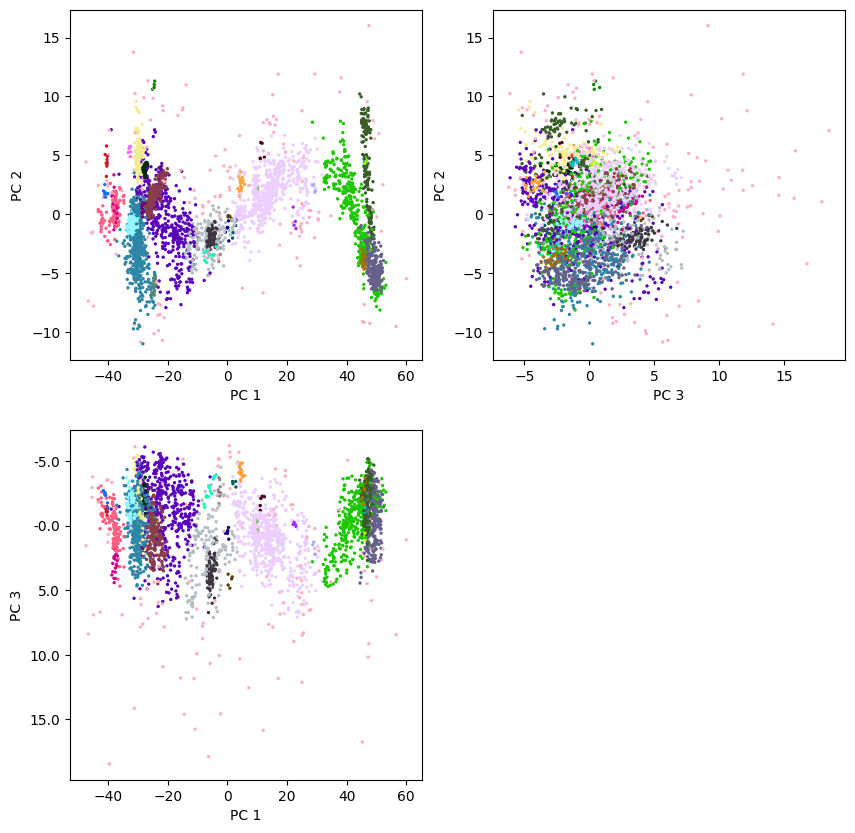

In [218]:
fig, ax = plot_components(landers, lab_plan, 2, cmap)